In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
import torch.nn as nn

import matplotlib.pyplot as plt

# 1. define your dataloader

In [2]:
transform_list = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.131], std=[0.289])])
dataset = datasets.MNIST(root='/tmp/', train=True, download=True, transform=transform_list)
dataset = Subset(dataset, range(2000))

loader = torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=500,
      shuffle=False)

# 2. define your model

In [3]:
n_hidden = 2
hidden_size = 10
device = 'cuda'
layers = [nn.Flatten(), nn.Linear(28 * 28, hidden_size), nn.ReLU()] + \
         [nn.Linear(hidden_size, hidden_size), nn.ReLU()] * (n_hidden - 1) + \
         [nn.Linear(hidden_size, 10), nn.LogSoftmax(dim=1)]
model = nn.Sequential(*layers).to(device)

# EWC penalty

We now compute the matrices coefficients using the generator above. Using different representations we get different performances, and also we use more or less memory. But low memory footprint comes at the price of a less accurate approximation of the FIM, and so the gradient that we get from the penalty can be drastically different.

In [4]:
from nngeometry.object import PMatKFAC, PMatDiag, PMatBlockDiag, PMatDense, PVector
from nngeometry.metrics import FIM

Suppose we now train our model on task 1. We want to store the current state of the network using:
 1. the current parameter values `v1`
 2. the current Fisher Information Matrix `F_XXX`

In [5]:
v1 = PVector.from_model(model).clone().detach()

F_kfac = FIM(model=model,
             loader=loader,
             representation=PMatKFAC,
             n_output=10,
             variant='classif_logits',
             device='cuda')

F_blockdiag = FIM(model=model,
                  loader=loader,
                  representation=PMatBlockDiag,
                  n_output=10,
                  variant='classif_logits',
                  device='cuda')

F_dense = FIM(model=model,
             loader=loader,
             representation=PMatDense,
             n_output=10,
             variant='classif_logits',
             device='cuda')


F_diag = FIM(model=model,
             loader=loader,
             representation=PMatDiag,
             n_output=10,
             variant='classif_logits',
             device='cuda')

We can now continue training, using an additional regularizer term, that uses the FIM and the difference betweem the current parameter value and `v1`

In [6]:
v_current = PVector.from_model(model)

you can now compute a regularizer scalar object and backward through it

In [7]:
regularizer_dense = F_dense.vTMv(v_current - v1)
regularizer_dense.backward()
[(p.size(), p.grad) for p in model.parameters()]

[(torch.Size([10, 784]),
  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')),
 (torch.Size([10]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')),
 (torch.Size([10, 10]),
  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')),
 (torch.Size([10]),
  tensor([0., 

note that in this case all gradients stay at `0`, because `v_current = v1`, so for the purpose of this example, we will modify the value of `v_current`. You can think of this modification as resulting from SGD updates on the first iterations of training on task 2.

In [8]:
for p in model.parameters():
    p.data.add_(torch.randn_like(p))

We now recompute the gradients from the regularizer:

In [9]:
regularizer_dense = F_dense.vTMv(v_current - v1)
regularizer_dense.backward()
[(p.size(), p.grad) for p in model.parameters()]

[(torch.Size([10, 784]),
  tensor([[-0.0208, -0.0208, -0.0208,  ..., -0.0208, -0.0208, -0.0208],
          [ 0.0048,  0.0048,  0.0048,  ...,  0.0048,  0.0048,  0.0048],
          [-0.0100, -0.0100, -0.0100,  ..., -0.0100, -0.0100, -0.0100],
          ...,
          [-0.0083, -0.0083, -0.0083,  ..., -0.0083, -0.0083, -0.0083],
          [ 0.0108,  0.0108,  0.0108,  ...,  0.0108,  0.0108,  0.0108],
          [ 0.0092,  0.0092,  0.0092,  ...,  0.0092,  0.0092,  0.0092]],
         device='cuda:0')),
 (torch.Size([10]),
  tensor([ 4.5806e-02, -1.0648e-02,  2.2162e-02,  1.6513e-02,  5.7909e-02,
           6.4793e-05,  3.5788e-02,  1.8260e-02, -2.3724e-02, -2.0362e-02],
         device='cuda:0')),
 (torch.Size([10, 10]),
  tensor([[ 1.2742e-02,  1.0406e-02,  3.1267e-03,  3.2303e-03,  5.1789e-02,
           -4.6293e-03,  2.0001e-02,  2.7142e-02, -2.9179e-03,  2.2821e-03],
          [ 1.3446e-04, -2.6562e-06,  1.6336e-04,  3.7881e-04,  9.9114e-05,
           -8.8303e-05, -2.3306e-06, -9.3934e-0

# Comparison of regularization obtained using different representations

In [10]:
model.zero_grad()
regularizer_dense = F_dense.vTMv(v_current - v1)
regularizer_dense.backward()
g_dense = torch.cat([p.grad.view(-1) for p in model.parameters()])

In [11]:
model.zero_grad()
regularizer_bd = F_blockdiag.vTMv(v_current - v1)
regularizer_bd.backward()
g_bd = torch.cat([p.grad.view(-1) for p in model.parameters()])

In [12]:
model.zero_grad()
regularizer_kfac = F_kfac.vTMv(v_current - v1)
regularizer_kfac.backward()
g_kfac = torch.cat([p.grad.view(-1) for p in model.parameters()])

In [13]:
model.zero_grad()
regularizer_diag = F_diag.vTMv(v_current - v1)
regularizer_diag.backward()
g_diag = torch.cat([p.grad.view(-1) for p in model.parameters()])

Text(0.5, 1.0, 'Compare 100 elements of the gradient (first layer)')

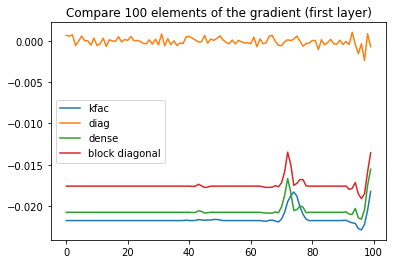

In [14]:
plt.plot(g_kfac[:100].cpu().numpy(), label='kfac')
plt.plot(g_diag[:100].cpu().numpy(), label='diag')
plt.plot(g_dense[:100].cpu().numpy(), label='dense')
plt.plot(g_bd[:100].cpu().numpy(), label='block diagonal')
plt.legend()
plt.title('Compare 100 elements of the gradient (first layer)')

Text(0.5, 1.0, 'Compare 100 elements of the gradient (last layer)')

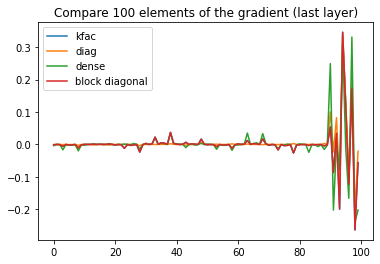

In [15]:
plt.plot(g_kfac[-100:].cpu().numpy(), label='kfac')
plt.plot(g_diag[-100:].cpu().numpy(), label='diag')
plt.plot(g_dense[-100:].cpu().numpy(), label='dense')
plt.plot(g_bd[-100:].cpu().numpy(), label='block diagonal')
# plt.ylim(-.01, .01)
plt.legend()
plt.title('Compare 100 elements of the gradient (last layer)')

# KFAC and Batch norm layers

In the case of the KFAC representation, it is not clear what to do with batch norm parameters. If you want to be able to use batch norm layers, you should instead mix representations. You can for instance use the block diagonal representation for batch norm layers, and still use KFAC for the linear layers.

Here is how, let us start by defining a new network with batch norm layers:

In [16]:
layers = [nn.Flatten(), nn.Linear(28 * 28, hidden_size), nn.ReLU()] + \
         [nn.Linear(hidden_size, hidden_size), nn.BatchNorm1d(hidden_size), nn.ReLU()] * (n_hidden - 1) + \
         [nn.Linear(hidden_size, 10), nn.LogSoftmax(dim=1)]
model = nn.Sequential(*layers).to(device)

We now create 2 different layer collections, one that will contain all linear layers, the other ones only batch norm layers.

In [17]:
from nngeometry.layercollection import LayerCollection

layer_collection_bn = LayerCollection()
layer_collection_linear = LayerCollection()

for mod in layers:
    if type(mod) in [torch.nn.modules.linear.Linear]:
        layer_collection_linear.add_layer_from_model(model, mod)
    elif type(mod) in [torch.nn.modules.batchnorm.BatchNorm1d]:
        layer_collection_bn.add_layer_from_model(model, mod)

We now create our 2 representations.

Note that both representations do not use the same layer collection, even if they come from the same model.

In [18]:
F_linear_kfac = FIM(layer_collection=layer_collection_linear,
                    model=model,
                    loader=loader,
                    representation=PMatKFAC,
                    n_output=10,
                    variant='classif_logits',
                    device='cuda')

F_bn_blockdiag = FIM(layer_collection=layer_collection_bn,
                     model=model,
                     loader=loader,
                     representation=PMatBlockDiag,
                     n_output=10,
                     variant='classif_logits',
                     device='cuda')

F_bn_blockdiag.size(), F_linear_kfac.size()

((20, 20), (8070, 8070))

In [19]:
v_current = PVector.from_model(model)

In [20]:
F_linear_kfac.vTMv(v_current), F_bn_blockdiag.vTMv(v_current)

(tensor(0.3414, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>))

We can create a new regularizer as the sum of the contributions of linear layers and batch norm layers:

In [21]:
regularizer = F_linear_kfac.vTMv(v_current) + F_bn_blockdiag.vTMv(v_current)

model.zero_grad()
regularizer.backward()
g_with_bn = torch.cat([p.grad.view(-1) for p in model.parameters()])

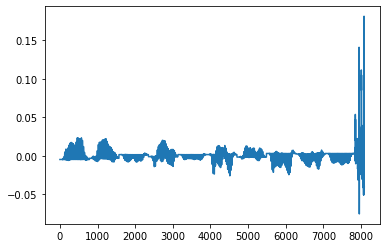

In [22]:
plt.plot(g_with_bn.cpu().numpy())